## <span style="color: #a9af90">1 | </span><span style="color: #586c5c">Information</span>

**Rice Classification Using CNN Models**

Rice, one of the most widely produced grains globally, has numerous genetic varieties distinguishable by features such as texture, shape, and color. These features not only separate rice varieties but also enable classification and quality evaluation of grains.

This study focuses on five rice varieties commonly grown in Turkey: Arborio, Basmati, Ipsala, Jasmine, and Karacadag. The dataset includes 75,000 images, with 15,000 samples for each variety.

Two Convolutional Neural Network (CNN) models were developed to classify the rice varieties based on the image dataset. The **Simple** model achieved an accuracy of **98%** while the **Complex** model achieved an accuracy of **99%** on training data, demonstrating its effectiveness in distinguishing between different rice types.

## <span style="color: #a9af90">2 | </span><span style="color: #586c5c">Libraries</span>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## <span style="color: #a9af90">3 | </span><span style="color: #586c5c">Pre Processing</span>

### <span style="color: #a9af90;">3.1 | </span><span style="color: #85937a">Creating DataFrame</span>

In [2]:
dataset_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

image_paths = []
image_labels = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if not os.path.isdir(category_path):
        continue

    for file in os.listdir(category_path):
        file_path = os.path.join(category_path, file)
        image_paths.append(file_path)
        image_labels.append(category)

df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

In [3]:
df

,image_path,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
...,...,...
74995,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
74996,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
74997,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
74998,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala


### <span style="color: #a9af90;">3.2 | </span><span style="color: #85937a">Organize dataset into train/val/test folders</span>

In [4]:
train_df, temp_df = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.4, stratify=temp_df['label'], random_state=42)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 56250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


### <span style="color: #a9af90;">3.3 | </span><span style="color: #85937a">Creating Some Plots</span>

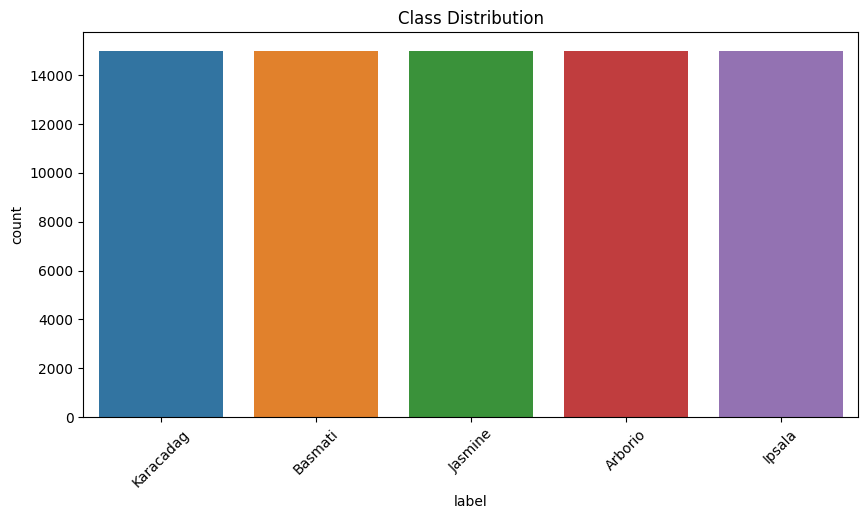

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

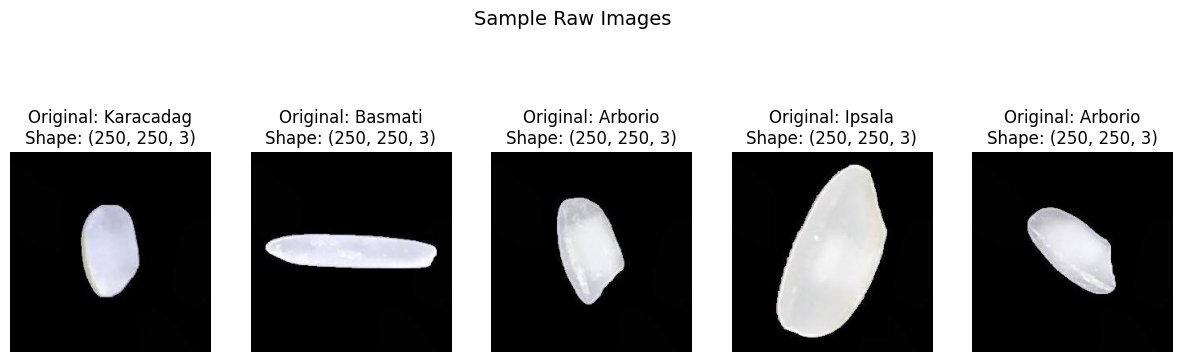

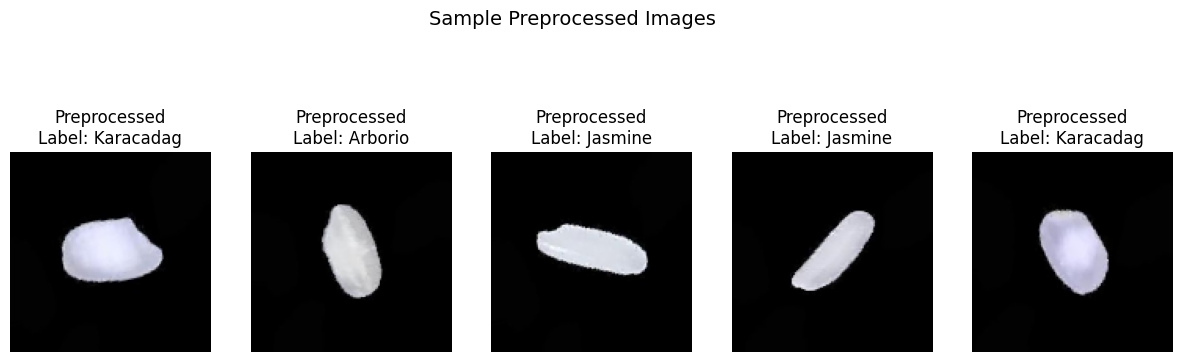

In [7]:
import matplotlib.pyplot as plt

def plot_sample_images(df, n=5):
    plt.figure(figsize=(15, 5))
    for i, (idx, row) in enumerate(df.sample(n).iterrows()):
        img = plt.imread(row['image_path'])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Original: {row['label']}\nShape: {img.shape}")
        plt.axis('off')
    plt.suptitle('Sample Raw Images', fontsize=14)
    plt.show()

def plot_preprocessed_images(generator, n=5):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(f"Preprocessed\nLabel: {class_names[np.argmax(labels[i])]}")
        plt.axis('off')
    plt.suptitle('Sample Preprocessed Images', fontsize=14)
    plt.show()

plot_sample_images(df)  # Raw images
plot_preprocessed_images(train_generator)  # Preprocessed

## <span style="color: #a9af90">4 | </span><span style="color: #586c5c">Building the CNN Model</span>

### <span style="color: #a9af90;">4.1 | </span><span style="color: #85937a">Create a Simple Model</span>

In [8]:
simple_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

simple_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
simple_history = simple_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1758/1758 ━━━━━━━━━━━━━━━━━━━━ 548s 308ms/step - accuracy: 0.8730 - loss: 0.3317 - val_accuracy: 0.9803 - val_loss: 0.0595
Epoch 2/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 303s 172ms/step - accuracy: 0.9748 - loss: 0.0747 - val_accuracy: 0.9884 - val_loss: 0.0341
Epoch 3/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 279s 158ms/step - accuracy: 0.9803 - loss: 0.0600 - val_accuracy: 0.9498 - val_loss: 0.1527
Epoch 4/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 269s 153ms/step - accuracy: 0.9812 - loss: 0.0547 - val_accuracy: 0.9859 - val_loss: 0.0463
Epoch 5/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 268s 152ms/step - accuracy: 0.9831 - loss: 0.0468 - val_accuracy: 0.9876 - val_loss: 0.0412
Epoch 6/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 274s 155ms/step - accuracy: 0.9870 - loss: 0.0402 - val_accuracy: 0.9667 - val_loss: 0.1192
Epoch 7/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 273s 155ms/step - accuracy: 0.9895 - loss: 0.0321 - val_accuracy: 0.9342 - val_loss: 0.2631
Epoch 8/15
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 264s 150ms/step - accuracy: 0.9

### <span style="color: #a9af90;">4.2 | </span><span style="color: #85937a">Create a Complex Model</span>

In [11]:
complex_model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

complex_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
complex_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,065,797 (99.43 MB)

 Trainable params: 26,064,901 (99.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
complex_history = complex_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 307s 168ms/step - accuracy: 0.8606 - loss: 0.5797 - val_accuracy: 0.8984 - val_loss: 0.2729
Epoch 2/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 281s 159ms/step - accuracy: 0.9581 - loss: 0.1236 - val_accuracy: 0.9387 - val_loss: 0.1734
Epoch 3/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 280s 159ms/step - accuracy: 0.9746 - loss: 0.0799 - val_accuracy: 0.9841 - val_loss: 0.0573
Epoch 4/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 280s 159ms/step - accuracy: 0.9819 - loss: 0.0532 - val_accuracy: 0.9861 - val_loss: 0.0527
Epoch 5/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 272s 154ms/step - accuracy: 0.9844 - loss: 0.0501 - val_accuracy: 0.9916 - val_loss: 0.0307
Epoch 6/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 269s 153ms/step - accuracy: 0.9862 - loss: 0.0461 - val_accuracy: 0.9954 - val_loss: 0.0177
Epoch 7/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 280s 158ms/step - accuracy: 0.9892 - loss: 0.0400 - val_accuracy: 0.9919 - val_loss: 0.0269
Epoch 8/20
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 287s 162ms/step - ac

## <span style="color: #a9af90">5 | </span><span style="color: #586c5c">Plotting to Analyze Better</span>

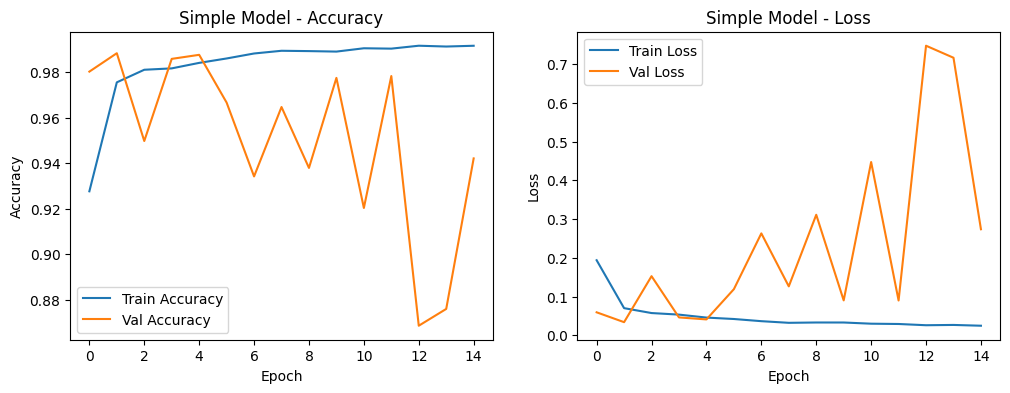

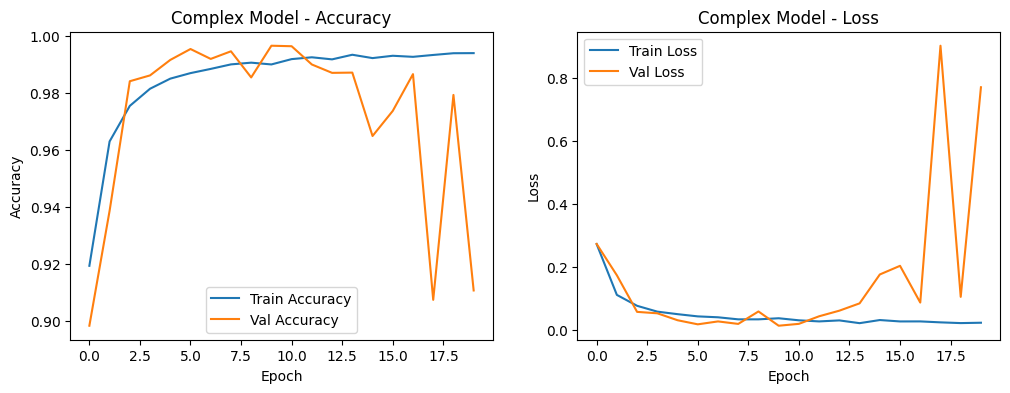

In [14]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(simple_history, 'Simple Model')
plot_history(complex_history, 'Complex Model')

## <span style="color: #a9af90">6 | </span><span style="color: #586c5c">Testing Models</span>

### <span style="color: #a9af90;">6.1 | </span><span style="color: #85937a">Evaluate Simple Model</span>

In [15]:
simple_test_loss, simple_test_acc = simple_model.evaluate(test_generator)
print(f"Simple Model - Test Accuracy: {simple_test_acc:.4f}, Test Loss: {simple_test_loss:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - accuracy: 0.9430 - loss: 0.2822
Simple Model - Test Accuracy: 0.9428, Test Loss: 0.2829


### <span style="color: #a9af90;">6.2 | </span><span style="color: #85937a">Evaluate Complex Model</span>

In [16]:
complex_test_loss, complex_test_acc = complex_model.evaluate(test_generator)
print(f"Complex Model - Test Accuracy: {complex_test_acc:.4f}, Test Loss: {complex_test_loss:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9097 - loss: 0.7226
Complex Model - Test Accuracy: 0.9069, Test Loss: 0.7500


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

def get_predictions(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred, axis=1)
    return y_true, y_pred

y_true_simple, y_pred_simple = get_predictions(simple_model, test_generator)
y_true_complex, y_pred_complex = get_predictions(complex_model, test_generator)

print("Simple Model Classification Report:")
print(classification_report(y_true_simple, y_pred_simple, target_names=test_generator.class_indices.keys()))

print("\nComplex Model Classification Report:")
print(classification_report(y_true_complex, y_pred_complex, target_names=test_generator.class_indices.keys()))

235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step
Simple Model Classification Report:
              precision    recall  f1-score   support

     Arborio       0.99      0.77      0.87      1500
     Basmati       0.97      0.99      0.98      1500
      Ipsala       0.81      1.00      0.89      1500
     Jasmine       0.99      0.96      0.97      1500
   Karacadag       1.00      0.99      0.99      1500

    accuracy                           0.94      7500
   macro avg       0.95      0.94      0.94      7500
weighted avg       0.95      0.94      0.94      7500


Complex Model Classification Report:
              precision    recall  f1-score   support

     Arborio       0.79      0.88      0.83      1500
     Basmati       1.00      0.93      0.97      1500
      Ipsala       0.87      1.00      0.93      1500
     Jasmine       0.93      0.99      0.96      1500
   Karacadag       1.00      0.72      0.84      1500

    accuracy             

### <span style="color: #a9af90;">6.3 | </span><span style="color: #85937a">Plotting the Testing Results</span>

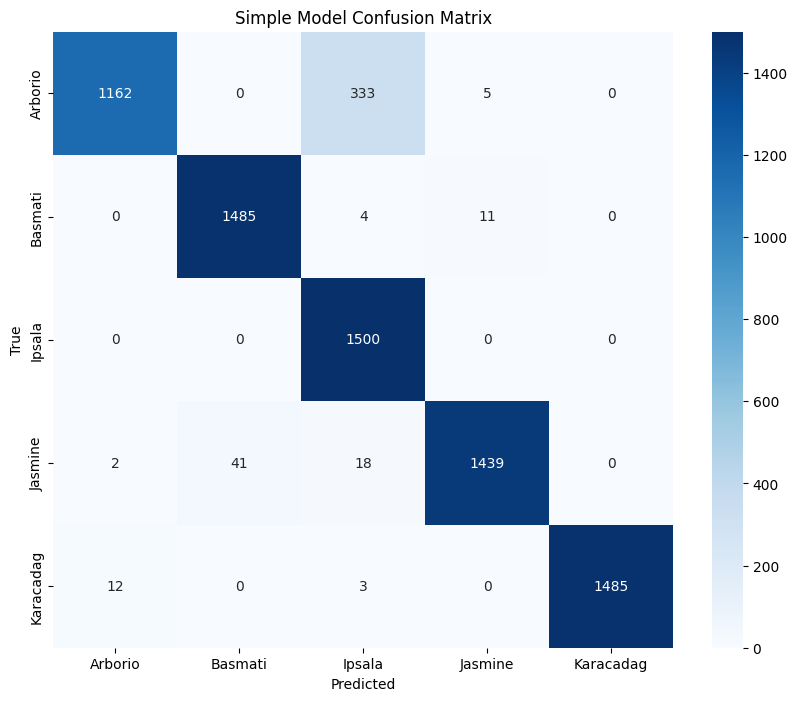

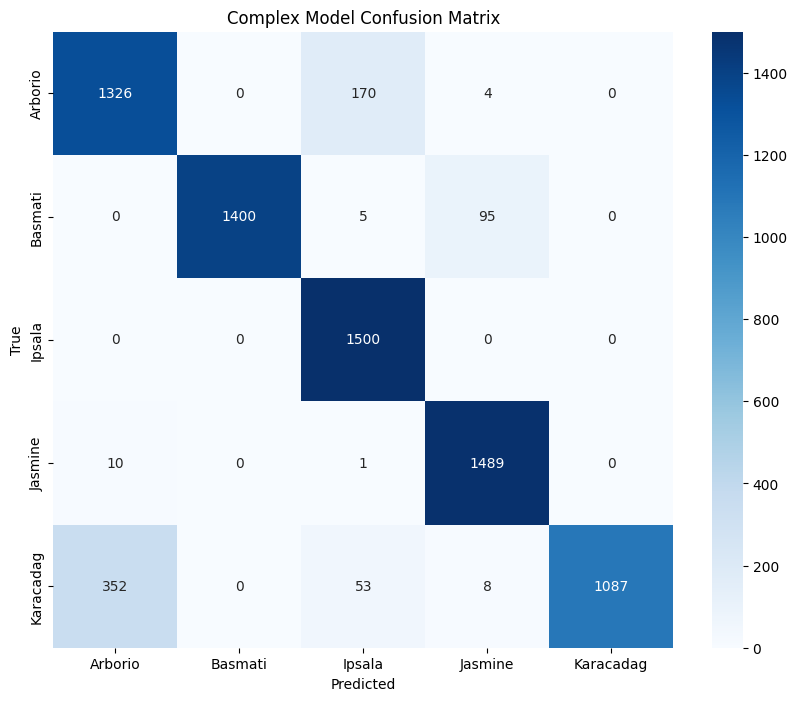

In [18]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

class_names = list(test_generator.class_indices.keys())

plot_confusion_matrix(y_true_simple, y_pred_simple, class_names, 'Simple Model Confusion Matrix')
plot_confusion_matrix(y_true_complex, y_pred_complex, class_names, 'Complex Model Confusion Matrix')

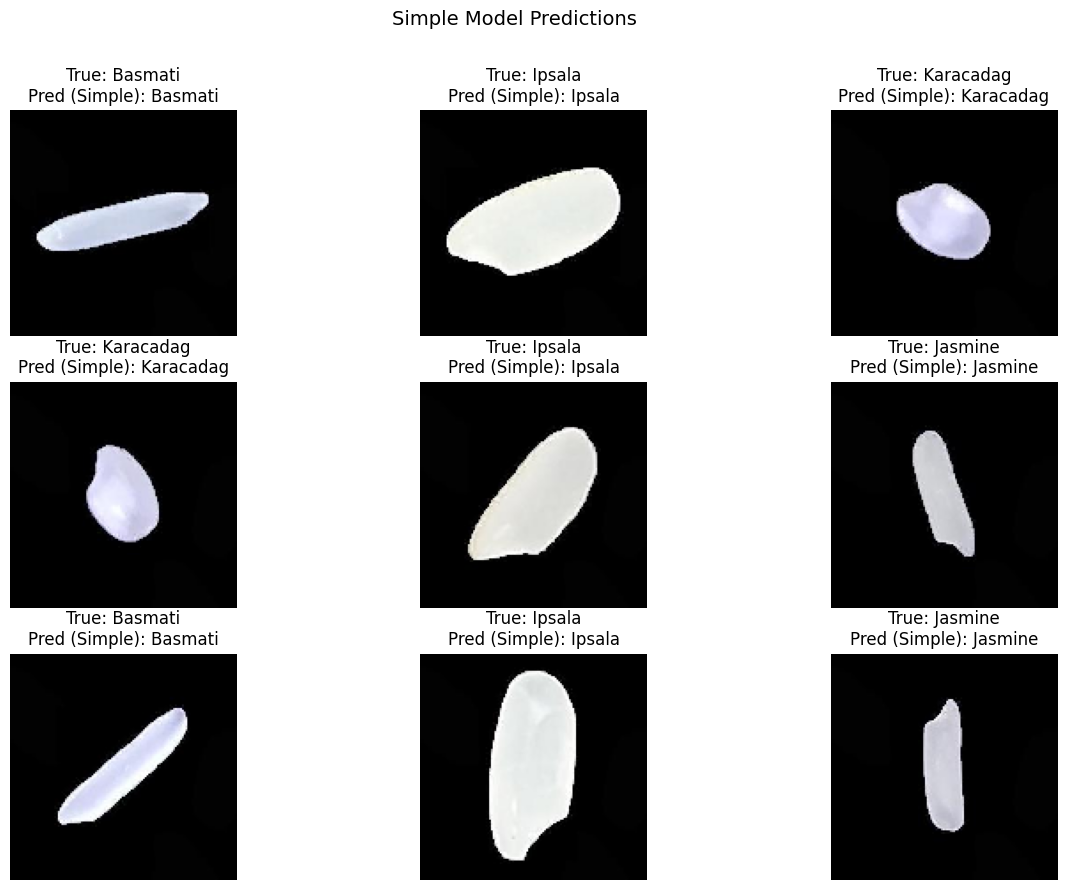

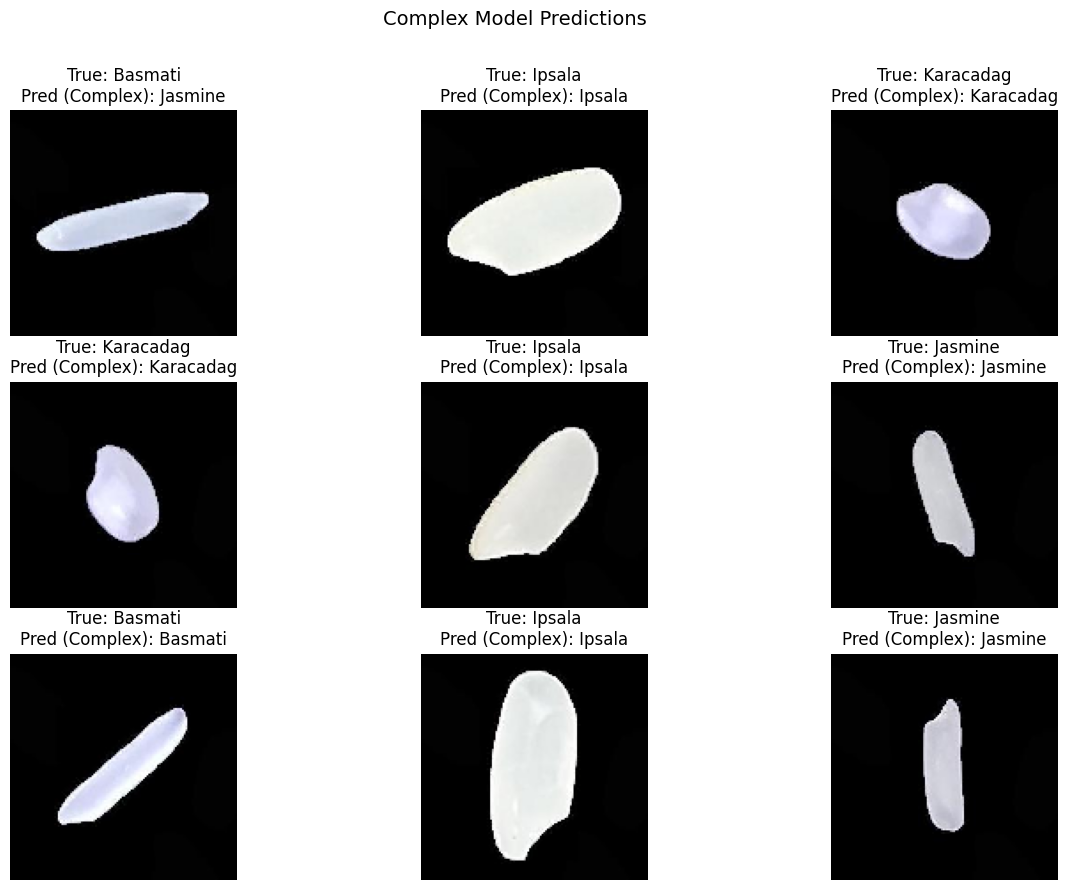

In [19]:
test_images, test_labels = next(test_generator)

# Plot predictions for Simple Model
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    pred_label = np.argmax(simple_model.predict(tf.expand_dims(test_images[i], 0), verbose=0))
    true_label = np.argmax(test_labels[i])
    plt.title(f"True: {class_names[true_label]}\nPred (Simple): {class_names[pred_label]}")
    plt.axis('off')
plt.suptitle('Simple Model Predictions', fontsize=14)
plt.show()

# Plot predictions for Complex Model
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    pred_label = np.argmax(complex_model.predict(tf.expand_dims(test_images[i], 0), verbose=0))
    true_label = np.argmax(test_labels[i])
    plt.title(f"True: {class_names[true_label]}\nPred (Complex): {class_names[pred_label]}")
    plt.axis('off')
plt.suptitle('Complex Model Predictions', fontsize=14)
plt.show()

# <span style="color: #85937a">The End!</span>
### <span style="color: #586c5c">Mohammad Soroush Esnaashari</span>